In [ ]:
# !pip install wandb --upgrade
# !pip install keras

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [138]:
# Importing relevant libraries
import numpy as np
import torch
# import tensorflow as tf
import keras
import matplotlib.pyplot as plt
# from keras.datasets import mnist

from pprint import pprint

In [111]:
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn

In [112]:
import time

In [137]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
GeForce 920M
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [227]:
# Directories to store the models and plots
# direc_main = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A4_RNN/'
# direc_pics = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A4_RNN/pics/'

direc_main = 'F:\Semester_7\Advanced_Signal_Processing\Lab Exercises\Lab4\models\\'
direc_pics = 'F:\Semester_7\Advanced_Signal_Processing\Lab Exercises\Lab4\pics\\'
# F:\Semester_7\Advanced_Signal_Processing\Lab Exercises\Lab4

# Data Loading

## From Keras

In [115]:
def loadMNIST(return_images=False, is_val_split=False, val_samples=10000, seed_value=1):
    '''
    ################
    Function which returns a dictionary containing the shuffled version of the MNIST dataset.
    Arguments:
    return_images   [bool]  Whether we need to return images            (default: False)
                                True: returns images
                                False: returns flattened vectors
    is_val_split    [bool]  Whether validation split needs to be done   (default: False)
                                True: returns train(60K-val_samples), validation(val_samples) and test(10K)
                                False: returns train(60K) and test(10K)
    val_samples     [int]   Number of validation samples to take out of the training set of 60K samples     (default: 10K)
    seed            [int]   Seed value for the numpy random shuffling   (default: 1)
    ########
    Return:
    Dictionary containing the numpy arrays corresponding to train, test and val(if is_val_split==True)
                    dict:   train:  X
                                    y
                            test:   X
                                    y
                            val:    X           (if is_val_split == True)
                                    y           (if is_val_split == True)
    ################
    '''

    # Loading MNIST data onto numpy arrays
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Shuffling data
    np.random.seed(seed_value)
    train_shuffler = np.random.permutation(60000)
    x_train, y_train = x_train[train_shuffler], y_train[train_shuffler]
    test_shuffler = np.random.permutation(10000)
    x_test, y_test = x_test[test_shuffler], y_test[test_shuffler]

    # Normalizing the input data
    x_train = np.array(x_train/255.0, dtype='float32')
    x_test = np.array(x_test/255.0, dtype='float32')

    ## Splitting data appropriately
    # Number of training samples 
    train_samples = 60000 - val_samples

    if is_val_split == True:
        # Splitting the train set into the new train and val sets
        x_train, x_val = x_train[:train_samples], x_train[train_samples:]
        y_train, y_val = y_train[:train_samples], y_train[train_samples:]

        # Flattening the 28x28 images into vectors and then returning
        if (return_images==False):
            return {
                'train':{
                    'X': x_train.reshape([train_samples, 784]),
                    'Y': y_train.reshape([train_samples])
                },
                'val':{
                    'X': x_val.reshape([val_samples, 784]),
                    'Y': y_val.reshape([val_samples])
                },
                'test':{
                    'X': x_test.reshape([10000, 784]),
                    'Y': y_test.reshape([10000])
                }
            }
        # Returning the 28x28 images as is
        else :
            return {
                'train':{
                    'X': x_train,
                    'Y': y_train
                },
                'val':{
                    'X': x_val,
                    'Y': y_val
                },
                'test':{
                    'X': x_test,
                    'Y': y_test
                }
            }
    # Training set is not split
    else:
        # Flattening the images and then returning
        if (return_images==False):
            return {
                'train':{
                    'X': x_train.reshape([60000, 784]),
                    'Y': y_train.reshape([60000])
                },
                'test':{
                    'X': x_test.reshape([10000, 784]),
                    'Y': y_test.reshape([10000])
                }
            }
        # Returning the images as is
        else :
            return {
                'train':{
                    'X': x_train,
                    'Y': y_train
                },
                'test':{
                    'X': x_test,
                    'Y': y_test
                }
            }

In [119]:
def makeOneHot(data):
    """
    Function to make the numeric labels into one-hot representation.
    Arguments:
    data            Dictionary as generated by loadMNIST()

    Returns:
    Similar dictionary as data but with one-hot arrays for the labels
    """
    # Initializing the dict
    data_mod = {}
    for key in data:
        data_mod[key] = {}
        data_mod[key]['X'] = data[key]['X']
        y = np.zeros((data[key]['Y'].shape[0], 10))
        y[range(data[key]['Y'].shape[0]), data[key]['Y']] = 1
        data_mod[key]['Y'] = y

    return data_mod

In [120]:
# Loading data as flattened vectors with a validation set
val_samples = 10000
data = loadMNIST(return_images=True, is_val_split=True, val_samples=val_samples, seed_value=1)
data_oh = makeOneHot(data)

# print(data_oh.keys())
# print(data_oh['train']['X'][0,0].shape)
# print(data_oh['train']['Y'].shape)
# print(data_oh['test']['X'].shape)
# print(data_oh['test']['Y'].shape)
# print(data_oh['val']['X'].shape)
# print(data_oh['val']['Y'].shape)

# print(data['test']['Y'].shape)
# print(data['val']['Y'].shape)
# print(data['val']['Y'].shape)
# print(data_oh['val']['Y'][:8])
# print(data['val']['Y'][:8])


dict_keys(['train', 'val', 'test'])
(28,)
(50000, 10)
(10000, 28, 28)
(10000, 10)
(10000, 28, 28)
(10000, 10)
(10000,)
(10000,)
(10000,)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[2 0 6 1 9 0 2 8]


In [122]:
# Initializing pytorch dataset from the numpy datasets we have so far
data_torch = {
    'train': {
        'X': torch.from_numpy(data['train']['X']),
        'Y': torch.from_numpy(data['train']['Y'].astype(np.int64))
    },
    'test': {
        'X': torch.from_numpy(data['test']['X']),
        'Y': torch.from_numpy(data['test']['Y'].astype(np.int64))
    },
    'val':{
        'X': torch.from_numpy(data['val']['X']),
        'Y': torch.from_numpy(data['val']['Y'].astype(np.int64))
    }
}

train_data = torch.utils.data.TensorDataset(data_torch['train']['X'], data_torch['train']['Y'])
test_data = torch.utils.data.TensorDataset(data_torch['test']['X'], data_torch['test']['Y'])
val_data = torch.utils.data.TensorDataset(data_torch['val']['X'], data_torch['val']['Y'])

In [ ]:
# Plotting 25 random data points from the dataset to get an idea of the dataset
prefix = direc_pics + 'dset_'
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title('Number {}'.format(label), fontsize=9)
    plt.axis("off")
    plt.imshow(torch.reshape(img, (28,28)), cmap="gray")
plt.savefig(prefix + '25point.png',bbox_inches='tight')
plt.show()

In [123]:
# Train has 600 batches of size 100. Test and Val are just 1 batch.
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=10000, 
                                          shuffle=True, 
                                          num_workers=1),

    'val'   : torch.utils.data.DataLoader(val_data, 
                                          batch_size=val_samples, 
                                          shuffle=True, 
                                          num_workers=1),
}

# Training and Testing Functions

In [124]:
def train_loop(loaders, model, loss_fn, optimizer, interval=75):
    '''
    Function to train the model and log required information
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to train
    loss_fn                 The loss function we are trying to minimize
    optimizer               Optimizer that we will use
    interval                Interval between logging of loss & calculating test metrics [default: 75]
    Returns:    Dict containing lists of training losses and test losses.
    '''
    dataloader = loaders['train']
    size = len(dataloader.dataset)
    losses = []
    losses_test = []
    acc_test = []


    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        temp = model(X)
        loss = loss_fn(input=temp['out'], target=y)
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % interval == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            temp1 = test_loop(loaders, model, loss_fn, option='val')
            losses_test.append(temp1['loss'])
            acc_test.append(temp1['acc'])
        
    return {
        'losses': losses,
        'losses_test': losses_test,
        'acc_test': acc_test
    }


def test_loop(loaders, model, loss_fn, option='val'):
    '''
    Function to calculate loss and accuracy of the model on the test set.
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to test
    loss_fn                 The loss function we are trying to minimize in training
    option                  String to indicate which dataset to use for testing ['val', 'test']
    Returns:    Dict containing loss and accuracy of the model on the test dataset
    '''
    dataloader = loaders[option]
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            temp = model(X)
            test_loss += loss_fn(input=temp['out'], target=y).item()
            correct += (temp['preds'] == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"{'Validation' if option=='val' else 'Test'} Metrics: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {
        'loss': test_loss,
        'acc': 100*correct
    }


In [125]:
def train_loop_lite(loaders, model, loss_fn, optimizer, interval=75):
    '''
    Function to train the model and log required information. This is just a lighter version without all the loss logging.
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to train
    loss_fn                 The loss function we are trying to minimize
    optimizer               Optimizer that we will use
    interval                Interval between logging of loss & calculating test metrics [default: 75]
    Returns:    None
    '''
    dataloader = loaders['train']
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        temp = model(X)
        loss = loss_fn(input=temp['out'], target=y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % interval == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            test_loop_lite(loaders, model, loss_fn, option='val')


def test_loop_lite(loaders, model, loss_fn, option='val'):
    '''
    Function to calculate loss and accuracy of the model on the test set. This is just a lighter version without all the loss logging.
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to test
    loss_fn                 The loss function we are trying to minimize in training
    option                  String to indicate which dataset to use for testing ['val', 'test']
    Returns:    None
    '''
    dataloader = loaders[option]
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            temp = model(X)
            test_loss += loss_fn(input=temp['out'], target=y).item()
            correct += (temp['preds'] == y).type(torch.float).sum().item()

    correct /= size
    test_loss /= num_batches
    print(f"Test Metrics: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [127]:
def plotGraphs(losses, losses_test, acc_test, interval, prefix='', saving=True):
    '''
    Function to do all the relevant plotting of losses vs iterations
    Arguments:
    losses          List containing loss on the training set every iteration
    losses_test     List containing loss on the test set every 'interval' iterations
    acc_test        Accuracy of prediction on the test set every 'interval' iterations
    interval        Number of iterations between test set evaluations during training
    prefix          Prefix to be added to plot names when saving     (default: '')
    saving          Boolean to decide whether we want to save the plots     (default: True)
    '''
    # Number of iterations carried out during training
    num_iters = len(losses)

    plt.figure()
    plt.plot(np.arange(num_iters), losses)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Train Loss Plot')
    if saving:
        plt.savefig(prefix + '_train_loss.png',bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], losses_test)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Test Loss Plot')
    if saving:
        plt.savefig(prefix + '_test_loss.png',bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], acc_test)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Plot')
    if saving:
        plt.savefig(prefix + '_test_acc.png',bbox_inches='tight')
    plt.show()


# MNIST using RNN


## Vanilla RNN

In [128]:
class VanillaRNN(nn.Module):
    def __init__(self, n_neurons=128, num_layers=1, n_inputs=28, n_outputs=10):
        super(VanillaRNN, self).__init__()

        self.n_neurons = n_neurons
        self.num_layers = num_layers
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.rnn = nn.RNN(
            input_size=self.n_inputs,
            hidden_size=self.n_neurons,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)


    def forward(self, X):
        states, _ = self.rnn(X)
        fcout = self.FC(states[:,-1,:])
        out = nn.Softmax(dim=1)(fcout)
        preds = torch.argmax(out, dim=1)

        return {
			'in': X,
			'out': out,
			'preds': preds,
            'fcout': fcout,
			'states':states
		}

In [129]:
# Grid Search of Parameters
layers_list = [1,2]
neurons_list = [32,64]
metricsD = {}
for layer in layers_list:
    metricsD[layer] = {}
    for neuron in neurons_list:
        metricsD[layer][neuron] = {}

# Dictionary of models
modelsD = {}
for layer in layers_list:
    modelsD[layer] = {}
    for neuron in neurons_list:
        model = VanillaRNN(n_neurons=neuron, num_layers=layer)
        modelsD[layer][neuron] = model

# RNN1 = VanillaRNN(n_neurons=128, num_layers=1)
# print(RNN1)

In [130]:
# Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss()
# Number of Epochs
num_epochs = 1

In [ ]:
for layer in modelsD:
    for neuron in modelsD[layer]:
        model = modelsD[layer][neuron]
        print('\n&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&\n')
        print(f'CONFIGURATION: num_layers = {layer}, hidden_size = {neuron}')

        # Adam optimizer
        optimizer = optim.Adam(model.parameters())

        # Measuring time taken for the training process
        losses = []
        losses_test = []
        acc_test = []
        interval = 50
        start = time.time()
        for i in range(num_epochs):
            print(f"Epoch {i+1}\n-------------------------------")
            
            # Training the network for this epoch
            temp = train_loop(loaders, model, loss_fn, optimizer, interval)
            losses += temp['losses']
            losses_test += temp['losses_test']
            acc_test += temp['acc_test']

        # Testing on the validation set
        print('\n-----------------------------------------')
        print('Performance on the Validation set...')
        temp = test_loop(loaders, model, loss_fn, option='val')
        losses_test.append(temp['loss'])
        acc_test.append(temp['acc'])

        # Testing on the test set
        print('Performance on the Test set...')
        temp = test_loop(loaders, model, loss_fn, option='test')

        # Logging the losses and accuracies obtained
        metricsD[layer][neuron]['l'] = losses
        metricsD[layer][neuron]['lt'] = losses_test
        metricsD[layer][neuron]['at'] = acc_test

        end = time.time()
        print('-----------------------------------------')
        print('-----------------------------------------')
        print('Time taken for the training: {0:.5f} seconds'.format(end-start))
        print('-----------------------------------------')


In [ ]:
# Plotting the relevant graphs and plots
saving = False
dataloader = loaders['test']
for layer in modelsD:
    for neuron in modelsD[layer]:
        model = modelsD[layer][neuron]
        prefix = direc_pics + 'mnist_RNN_l{}_n{}'.format(layer, neuron)
        plotGraphs(
            losses = metricsD[layer][neuron]['l'],
            losses_test = metricsD[layer][neuron]['lt'],
            acc_test = metricsD[layer][neuron]['at'],
            interval = interval,
            prefix = prefix,
            saving = saving
        )

        # Plotting few pictures with true and predicted labels
        with torch.no_grad():
            for X, y in dataloader:
                temp = model(X)
            
            figure = plt.figure(figsize=(10, 10))
            cols, rows = 5, 5
            for i in range(1, cols * rows + 1):
                sample_idx = torch.randint(5000, size=(1,)).item()
                img, label = X[sample_idx], y[sample_idx]
                figure.add_subplot(rows, cols, i)
                plt.title('Truth: {} | Pred: {}'.format(label, temp['preds'][sample_idx]), fontsize=9)
                plt.axis("off")
                plt.imshow(img.squeeze(), cmap="gray")
            if saving:
                plt.savefig(prefix + '_samples.png',bbox_inches='tight')
            plt.show()


In [ ]:
# Saving the trained network
for layer in modelsD:
    for neuron in modelsD[layer]:
        torch.save(modelsD[layer][neuron], direc_main+'mnist_RNN_l{}_n{}.pth'.format(layer, neuron))


In [ ]:
# The exact same above has to be done with regularization on a new set of models


## GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, n_neurons=128, num_layers=1, n_inputs=28, n_outputs=10):
        super(GRU, self).__init__()
        
        self.n_neurons = n_neurons
        self.num_layers = num_layers
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.gru = nn.GRU(
            input_size=self.n_inputs,
            hidden_size=self.n_neurons,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def forward(self, X):
        states, _ = self.gru(X)
        fcout = self.FC(states[:,-1,:])
        out = nn.Softmax(dim=1)(fcout)
        preds = torch.argmax(out, dim=1)

        return {
			'in': X,
			'out': out,
			'preds': preds,
            'fcout': fcout,
			'states':states
		}


In [ ]:
# Grid Search of Parameters
layers_list = [1,2]
neurons_list = [32,64]
metricsD = {}
for layer in layers_list:
    metricsD[layer] = {}
    for neuron in neurons_list:
        metricsD[layer][neuron] = {}

# Dictionary of models
modelsD = {}
for layer in layers_list:
    modelsD[layer] = {}
    for neuron in neurons_list:
        model = GRU(n_neurons=neuron, num_layers=layer)
        modelsD[layer][neuron] = model


In [ ]:
# Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss()
# Number of Epochs
num_epochs = 1

In [ ]:
for layer in modelsD:
    for neuron in modelsD[layer]:
        model = modelsD[layer][neuron]
        print('\n&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&\n')
        print(f'CONFIGURATION: num_layers = {layer}, hidden_size = {neuron}')

        # Adam optimizer
        optimizer = optim.Adam(model.parameters())

        # Measuring time taken for the training process
        losses = []
        losses_test = []
        acc_test = []
        interval = 50
        start = time.time()
        for i in range(num_epochs):
            print(f"Epoch {i+1}\n-------------------------------")
            
            # Training the network for this epoch
            temp = train_loop(loaders, model, loss_fn, optimizer, interval)
            losses += temp['losses']
            losses_test += temp['losses_test']
            acc_test += temp['acc_test']

        # Testing on the validation set
        print('\n-----------------------------------------')
        print('Performance on the Validation set...')
        temp = test_loop(loaders, model, loss_fn, option='val')
        losses_test.append(temp['loss'])
        acc_test.append(temp['acc'])

        # Testing on the test set
        print('Performance on the Test set...')
        temp = test_loop(loaders, model, loss_fn, option='test')

        # Logging the losses and accuracies obtained
        metricsD[layer][neuron]['l'] = losses
        metricsD[layer][neuron]['lt'] = losses_test
        metricsD[layer][neuron]['at'] = acc_test

        end = time.time()
        print('-----------------------------------------')
        print('-----------------------------------------')
        print('Time taken for the training: {0:.5f} seconds'.format(end-start))
        print('-----------------------------------------')


In [ ]:
# Plotting the relevant graphs and plots
saving = False
dataloader = loaders['test']
for layer in modelsD:
    for neuron in modelsD[layer]:
        model = modelsD[layer][neuron]
        prefix = direc_pics + 'mnist_GRU_l{}_n{}'.format(layer, neuron)
        plotGraphs(
            losses = metricsD[layer][neuron]['l'],
            losses_test = metricsD[layer][neuron]['lt'],
            acc_test = metricsD[layer][neuron]['at'],
            interval = interval,
            prefix = prefix,
            saving = saving
        )

        # Plotting few pictures with true and predicted labels
        with torch.no_grad():
            for X, y in dataloader:
                temp = model(X)
            
            figure = plt.figure(figsize=(10, 10))
            cols, rows = 5, 5
            for i in range(1, cols * rows + 1):
                sample_idx = torch.randint(5000, size=(1,)).item()
                img, label = X[sample_idx], y[sample_idx]
                figure.add_subplot(rows, cols, i)
                plt.title('Truth: {} | Pred: {}'.format(label, temp['preds'][sample_idx]), fontsize=9)
                plt.axis("off")
                plt.imshow(img.squeeze(), cmap="gray")
            if saving:
                plt.savefig(prefix + '_samples.png',bbox_inches='tight')
            plt.show()


In [ ]:
# Saving the trained network
for layer in modelsD:
    for neuron in modelsD[layer]:
        torch.save(modelsD[layer][neuron], direc_main+'mnist_GRU_l{}_n{}.pth'.format(layer, neuron))


In [139]:
# The exact same above has to be done with regularization on a new set of models



## Bidirectional LSTM

In [144]:
class LSTM(nn.Module):
    def __init__(self, n_neurons=128, num_layers=1, n_inputs=28, n_outputs=10):
        super(LSTM, self).__init__()
        
        self.n_neurons = n_neurons
        self.num_layers = num_layers
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.lstm = nn.LSTM(
            input_size=self.n_inputs,
            hidden_size=self.n_neurons,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.FC = nn.Linear(2*self.n_neurons, self.n_outputs)

    def forward(self, X):
        states, _ = self.lstm(X)
        cat_states = torch.squeeze(torch.cat((states[:,-1,:self.n_neurons], states[:,0,self.n_neurons:]), dim=-1))
        fcout = self.FC(cat_states)
        out = nn.Softmax(dim=1)(fcout)
        preds = torch.argmax(out, dim=1)

        return {
			'in': X,
			'out': out,
			'preds': preds,
            'fcout': fcout,
			'states':states
		}

In [145]:
# Grid Search of Parameters
layers_list = [1,2]
neurons_list = [32,64]
metricsD = {}
for layer in layers_list:
    metricsD[layer] = {}
    for neuron in neurons_list:
        metricsD[layer][neuron] = {}

# Dictionary of models
modelsD = {}
for layer in layers_list:
    modelsD[layer] = {}
    for neuron in neurons_list:
        model = LSTM(n_neurons=neuron, num_layers=layer)
        modelsD[layer][neuron] = model


In [146]:
# Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss()
# Number of Epochs
num_epochs = 1

In [147]:
for layer in modelsD:
    for neuron in modelsD[layer]:
        model = modelsD[layer][neuron]
        print('\n&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&\n')
        print(f'CONFIGURATION: num_layers = {layer}, hidden_size = {neuron}')

        # Adam optimizer
        optimizer = optim.Adam(model.parameters())

        # Measuring time taken for the training process
        losses = []
        losses_test = []
        acc_test = []
        interval = 50
        start = time.time()
        for i in range(num_epochs):
            print(f"Epoch {i+1}\n-------------------------------")
            
            # Training the network for this epoch
            temp = train_loop(loaders, model, loss_fn, optimizer, interval)
            losses += temp['losses']
            losses_test += temp['losses_test']
            acc_test += temp['acc_test']

        # Testing on the validation set
        print('\n-----------------------------------------')
        print('Performance on the Validation set...')
        temp = test_loop(loaders, model, loss_fn, option='val')
        losses_test.append(temp['loss'])
        acc_test.append(temp['acc'])

        # Testing on the test set
        print('Performance on the Test set...')
        temp = test_loop(loaders, model, loss_fn, option='test')

        # Logging the losses and accuracies obtained
        metricsD[layer][neuron]['l'] = losses
        metricsD[layer][neuron]['lt'] = losses_test
        metricsD[layer][neuron]['at'] = acc_test

        end = time.time()
        print('-----------------------------------------')
        print('-----------------------------------------')
        print('Time taken for the training: {0:.5f} seconds'.format(end-start))
        print('-----------------------------------------')



&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

CONFIGURATION: num_layers = 1, hidden_size = 32
Epoch 1
-------------------------------
Loss: 2.303350  [    0/50000]
Validation Metrics: 
Accuracy: 10.1%, Avg loss: 2.302565 

Loss: 2.294485  [ 5000/50000]
Validation Metrics: 
Accuracy: 24.0%, Avg loss: 2.289308 

Loss: 2.143413  [10000/50000]
Validation Metrics: 
Accuracy: 38.9%, Avg loss: 2.096635 

Loss: 2.044663  [15000/50000]
Validation Metrics: 
Accuracy: 52.5%, Avg loss: 1.988896 

Loss: 1.889396  [20000/50000]
Validation Metrics: 
Accuracy: 60.4%, Avg loss: 1.901466 

Loss: 1.795694  [25000/50000]
Validation Metrics: 
Accuracy: 72.2%, Avg loss: 1.797722 

Loss: 1.748404  [30000/50000]
Validation Metrics: 
Accuracy: 73.0%, Avg loss: 1.769879 

Loss: 1.707993  [35000/50000]
Validation Metrics: 
Accuracy: 77.1%, Avg loss: 1.721586 

Loss: 1.658943  [40000/50000]
Validation Metrics: 
Accuracy: 77.7%, Avg loss: 1.705026 

Loss: 1.700945  [45000/50000]
Validation Metrics: 
Accur

In [ ]:
# Plotting the relevant graphs and plots
saving = False
dataloader = loaders['test']
for layer in modelsD:
    for neuron in modelsD[layer]:
        model = modelsD[layer][neuron]
        prefix = direc_pics + 'mnist_GRU_l{}_n{}'.format(layer, neuron)
        plotGraphs(
            losses = metricsD[layer][neuron]['l'],
            losses_test = metricsD[layer][neuron]['lt'],
            acc_test = metricsD[layer][neuron]['at'],
            interval = interval,
            prefix = prefix,
            saving = saving
        )

        # Plotting few pictures with true and predicted labels
        with torch.no_grad():
            for X, y in dataloader:
                temp = model(X)
            
            figure = plt.figure(figsize=(10, 10))
            cols, rows = 5, 5
            for i in range(1, cols * rows + 1):
                sample_idx = torch.randint(5000, size=(1,)).item()
                img, label = X[sample_idx], y[sample_idx]
                figure.add_subplot(rows, cols, i)
                plt.title('Truth: {} | Pred: {}'.format(label, temp['preds'][sample_idx]), fontsize=9)
                plt.axis("off")
                plt.imshow(img.squeeze(), cmap="gray")
            if saving:
                plt.savefig(prefix + '_samples.png',bbox_inches='tight')
            plt.show()


In [ ]:
# Saving the trained network
for layer in modelsD:
    for neuron in modelsD[layer]:
        torch.save(modelsD[layer][neuron], direc_main+'mnist_GRU_l{}_n{}.pth'.format(layer, neuron))


In [ ]:
# The exact same above has to be done with regularization on a new set of models


##  Remembering the number at a particular index in a sequence

### Dataset Preparation

In [213]:
elements_in_batch = 50
num_batches = 1000
position = 1
input_list = []
output_list = []
label_list = []

for i in range(num_batches):
    seqLength = np.random.randint(low=3, high=11)
    inptemp = torch.zeros(size=(elements_in_batch, seqLength, 10))
    outtemp = torch.zeros(size=(elements_in_batch, 10))
    labeltemp = torch.zeros(size=(elements_in_batch,))
    for j in range(elements_in_batch):
        for k in range(seqLength):
            temp = np.random.randint(low=0, high=10)
            inptemp[j,k,temp] = 1
            if k==position:
                outtemp[j,temp] = 1
                labeltemp[j] = temp
    
    input_list.append(inptemp)
    output_list.append(outtemp)
    label_list.append(labeltemp.type(torch.LongTensor))

# Splitting batches for training and testing
trainB = (4*num_batches)//5
train_data = list(zip(input_list[:trainB], output_list[:trainB], label_list[:trainB]))
test_data = list(zip(input_list[trainB:], output_list[trainB:], label_list[trainB:]))

loaders = {
    'train': train_data,
    'test': test_data
}


In [214]:
def train_loop_mod(loaders, model, loss_fn, optimizer, interval=75):
    '''
    Function to train the model and log required information
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to train
    loss_fn                 The loss function we are trying to minimize
    optimizer               Optimizer that we will use
    interval                Interval between logging of loss & calculating test metrics [default: 75]
    Returns:    Dict containing lists of training losses and test losses.
    '''
    dataloader = loaders['train']
    size = len(dataloader)*len(dataloader[0][2])
    losses = []
    losses_test = []
    acc_test = []


    for batch, iter in enumerate(dataloader):
        # Unpacking
        X, y, labels = iter
        
        # Compute prediction and loss
        temp = model(X)
        loss = loss_fn(input=temp['out'], target=labels)
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % interval == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            temp1 = test_loop_mod(loaders, model, loss_fn)
            losses_test.append(temp1['loss'])
            acc_test.append(temp1['acc'])
        
    return {
        'losses': losses,
        'losses_test': losses_test,
        'acc_test': acc_test
    }


def test_loop_mod(loaders, model, loss_fn):
    '''
    Function to calculate loss and accuracy of the model on the test set.
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to test
    loss_fn                 The loss function we are trying to minimize in training
    Returns:    Dict containing loss and accuracy of the model on the test dataset
    '''
    dataloader = loaders['test']
    size = len(dataloader)*len(dataloader[0][2])
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for iter in dataloader:
            # Unpacking
            X, y, labels = iter
            temp = model(X)
            test_loss += loss_fn(input=temp['out'], target=labels).item()
            correct += (temp['preds'] == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Metrics: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {
        'loss': test_loss,
        'acc': 100*correct
    }

### Models

In [221]:
sizes = [2,5,10]
models = [LSTM(n_neurons=n, num_layers=1, n_inputs=10, n_outputs=10) for n in sizes]
l_list = []
lt_list = []
at_list = []

In [222]:
# Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss()
# Number of Epochs
num_epochs = 3


In [223]:
for ind, model in enumerate(models):
    print('\n&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&\n')
    print(f'CONFIGURATION: hidden_size = {sizes[ind]}')

    # Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=5e-3)
    
    # Measuring time taken for the training process
    losses = []
    losses_test = []
    acc_test = []
    interval = 100
    start = time.time()
    for i in range(num_epochs):
        print(f"Epoch {i+1}\n-------------------------------")
        
        # Training the network for this epoch
        temp = train_loop_mod(loaders, model, loss_fn, optimizer, interval)
        losses += temp['losses']
        losses_test += temp['losses_test']
        acc_test += temp['acc_test']

    # Testing on the test set
    print('\n-----------------------------------------')
    print('Performance on the Test set...')
    temp = test_loop_mod(loaders, model, loss_fn)
    losses_test.append(temp['loss'])
    acc_test.append(temp['acc'])

    l_list.append(losses)
    lt_list.append(losses_test)
    at_list.append(acc_test)

    end = time.time()
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Time taken for the training: {0:.5f} seconds'.format(end-start))
    print('-----------------------------------------')



&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

CONFIGURATION: hidden_size = 2
Epoch 1
-------------------------------
Loss: 2.298536  [    0/40000]
Test Metrics: 
Accuracy: 9.5%, Avg loss: 2.303328 

Loss: 2.298663  [ 5000/40000]
Test Metrics: 
Accuracy: 15.7%, Avg loss: 2.288567 

Loss: 2.252349  [10000/40000]
Test Metrics: 
Accuracy: 22.4%, Avg loss: 2.247716 

Loss: 2.211038  [15000/40000]
Test Metrics: 
Accuracy: 24.9%, Avg loss: 2.211756 

Loss: 2.181761  [20000/40000]
Test Metrics: 
Accuracy: 32.3%, Avg loss: 2.159503 

Loss: 2.083009  [25000/40000]
Test Metrics: 
Accuracy: 35.8%, Avg loss: 2.121722 

Loss: 2.086807  [30000/40000]
Test Metrics: 
Accuracy: 36.2%, Avg loss: 2.110746 

Loss: 2.065526  [35000/40000]
Test Metrics: 
Accuracy: 37.2%, Avg loss: 2.102518 

Epoch 2
-------------------------------
Loss: 2.048990  [    0/40000]
Test Metrics: 
Accuracy: 37.3%, Avg loss: 2.097479 

Loss: 2.120711  [ 5000/40000]
Test Metrics: 
Accuracy: 37.9%, Avg loss: 2.091975 

Loss:

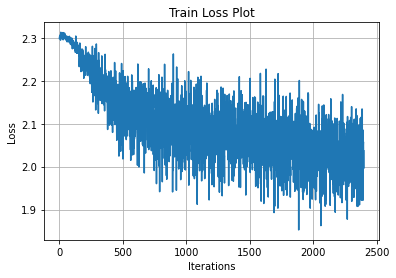

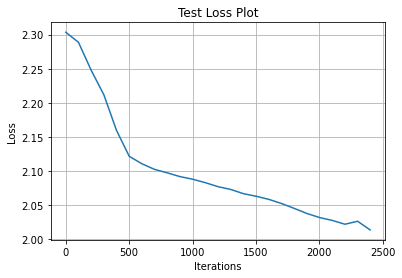

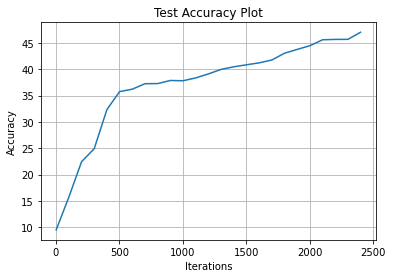

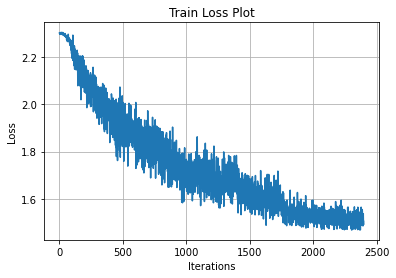

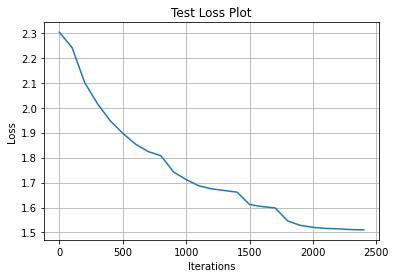

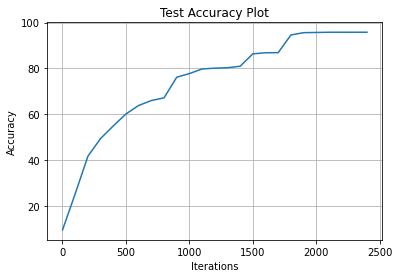

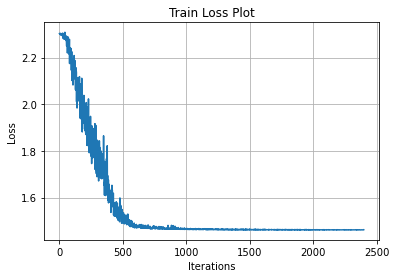

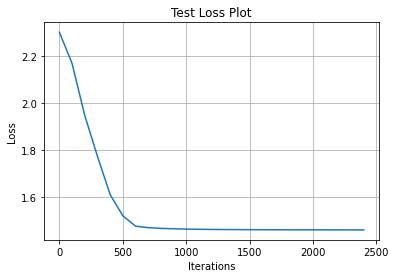

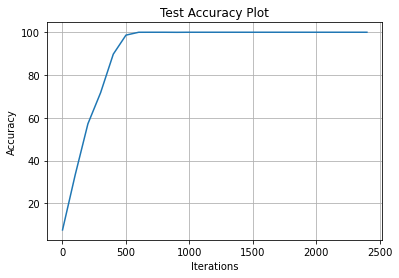

In [229]:
saving = True
for i in range(len(sizes)):
    prefix = direc_pics + 'text_LSTM_n{}'.format(sizes[i])
    plotGraphs(
        losses = l_list[i],
        losses_test = lt_list[i],
        acc_test = at_list[i],
        interval = interval,
        prefix = prefix,
        saving = saving
    )


In [230]:
for i, model in enumerate(models):
    torch.save(model, direc_main+'text_LSTM_n{}.pth'.format(sizes[i]))

### Showing examples for the best model (hidden_size=10)

In [240]:
# Testing the best model and printing the truth and model generated outputs
num_examples = 2
with torch.no_grad():
    model = models[-1]
    for length in range(3, 11):
        print(f'\nLength {length}:')
        for j in range(num_examples):
            input_ = torch.zeros(size=(2, length, 10))
            for k in range(length):
                number = np.random.randint(low=0, high=10)
                if k==length-1:
                    print(number, end='')
                else:
                    print(f'{number}, ', end='')
                input_[0, k, number] = 1
                if k==position:
                    truth = number
            
            output = model(input_)
            print(f'\tTruth: {truth}, Pred: {output["preds"][0]}')




Length 3:
3, 7, 5	Truth: 7, Pred: 7
2, 4, 6	Truth: 4, Pred: 4

Length 4:
8, 8, 7, 9	Truth: 8, Pred: 8
8, 8, 0, 7	Truth: 8, Pred: 8

Length 5:
7, 4, 7, 6, 8	Truth: 4, Pred: 4
6, 9, 2, 2, 8	Truth: 9, Pred: 9

Length 6:
0, 7, 2, 1, 8, 2	Truth: 7, Pred: 7
8, 3, 0, 3, 8, 2	Truth: 3, Pred: 3

Length 7:
5, 1, 8, 8, 9, 7, 3	Truth: 1, Pred: 1
6, 1, 1, 2, 0, 3, 6	Truth: 1, Pred: 1

Length 8:
4, 1, 5, 8, 2, 9, 5, 3	Truth: 1, Pred: 1
5, 2, 5, 0, 4, 3, 8, 5	Truth: 2, Pred: 2

Length 9:
2, 5, 8, 2, 1, 2, 9, 6, 9	Truth: 5, Pred: 5
0, 0, 8, 8, 8, 4, 9, 7, 1	Truth: 0, Pred: 0

Length 10:
2, 4, 2, 1, 4, 3, 1, 7, 9, 1	Truth: 4, Pred: 4
1, 5, 6, 5, 2, 1, 1, 9, 7, 8	Truth: 5, Pred: 5
